## Dataset

In [1]:
# Packages:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random as rn
import scipy.stats as ss
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import make_scorer, f1_score
from xgboost import XGBClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
# Loading dataset:
def load_data(file):
    df = pd.read_csv(file, sep = ";")
    return df

data = load_data("Student dropout.csv")

In [3]:
# Setting seed:
seed_value = 101

np.random.seed(seed_value)
rn.seed(seed_value)

In [4]:
# Categorically encoded features:
categorical_features = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 36]
data[data.columns[categorical_features]] = data[data.columns[categorical_features]].astype("category")

## Data pre-processing

### Feature engineering

In [5]:
# Encoding target into numerical:
def encode_target(df, variable):
    category_order = ["Graduate", "Dropout", "Enrolled"]
    df[variable] = df[variable].astype("category").cat.set_categories(category_order)
    df[variable].replace({"Graduate": 0, "Dropout": 1, "Enrolled": 2}, inplace=True)
    return df

data = encode_target(data, "Target")

# Encoding strings into floats:
def encode_strings(df, variable):
    df[variable] = df[variable].str[:4].astype(float)
    return df

data = encode_strings(data, "Curricular units 1st sem (grade)")
data = encode_strings(data, "Curricular units 2nd sem (grade)")

# Encoding into subgroups (highly educated > secondary):
def encode_parents_qualification(df, mother_col, father_col, new_col):
    highly_educated_values = [2, 3, 4, 5, 6, 39, 40, 41, 42, 43, 44]
    df[new_col] = ((df[mother_col].isin(highly_educated_values)) | (df[father_col].isin(highly_educated_values))).astype(int).astype("category")
    df.drop(columns=[mother_col, father_col], inplace=True)
    return df

data = encode_parents_qualification(data, "Mother's qualification", "Father's qualification", "Parents' qualification")

# Rounding floating variables:
def rounding(df, variable):
    df[variable] = round(df[variable], 1)
    return df

data = rounding(data, "GDP")

### Cleaning data

In [6]:
# Zero columns:
def count_zeros(df):
    numerical_columns = df.select_dtypes(include = [np.number]).columns
    zeros_count = df[numerical_columns].eq(0).sum()
    return zeros_count

print(count_zeros(data))

# Dropping columns with zeroes:
def dropping(df, variable):
    df = df.drop(variable, axis = 1)
    return df

data = dropping(data, ["Curricular units 1st sem (credited)", "Curricular units 2nd sem (credited)", "Curricular units 1st sem (without evaluations)", "Curricular units 2nd sem (without evaluations)"])

# Removing outliers:
def remove_num_outliers(df):
    numerical_columns = df.select_dtypes(include = np.number).columns
    Q1 = df[numerical_columns].quantile(0.25)
    Q3 = df[numerical_columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    df_cleaned = df.copy()
    for column in numerical_columns:
        df_cleaned = df_cleaned[~((df_cleaned[column] < lower_bound[column]) | (df_cleaned[column] > upper_bound[column]))]
    return df_cleaned

data = remove_num_outliers(data)

Previous qualification (grade)                       0
Admission grade                                      0
Age at enrollment                                    0
Curricular units 1st sem (credited)               3847
Curricular units 1st sem (enrolled)                180
Curricular units 1st sem (evaluations)             349
Curricular units 1st sem (approved)                718
Curricular units 1st sem (grade)                   718
Curricular units 1st sem (without evaluations)    4130
Curricular units 2nd sem (credited)               3894
Curricular units 2nd sem (enrolled)                180
Curricular units 2nd sem (evaluations)             401
Curricular units 2nd sem (approved)                870
Curricular units 2nd sem (grade)                   870
Curricular units 2nd sem (without evaluations)    4142
Unemployment rate                                    0
Inflation rate                                       0
GDP                                                  0
dtype: int

### Feature selection

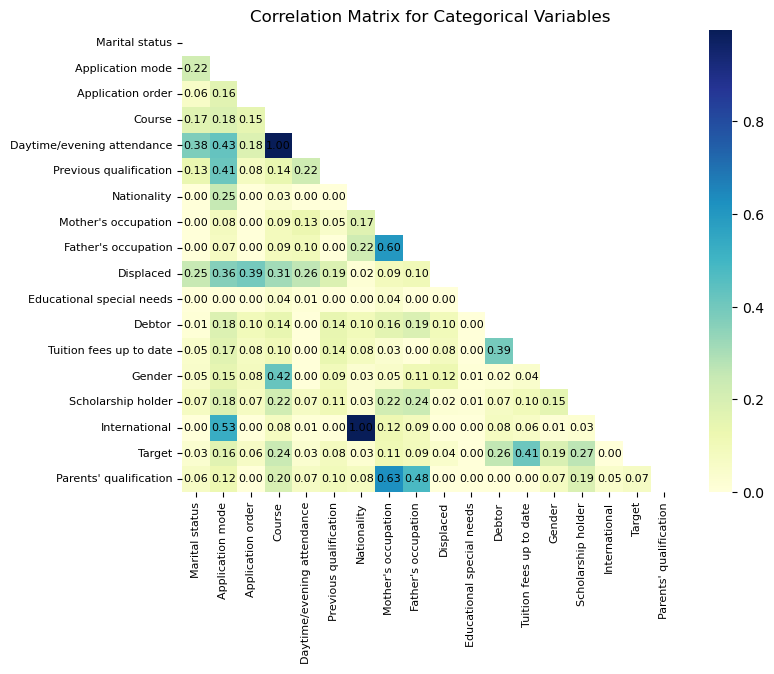

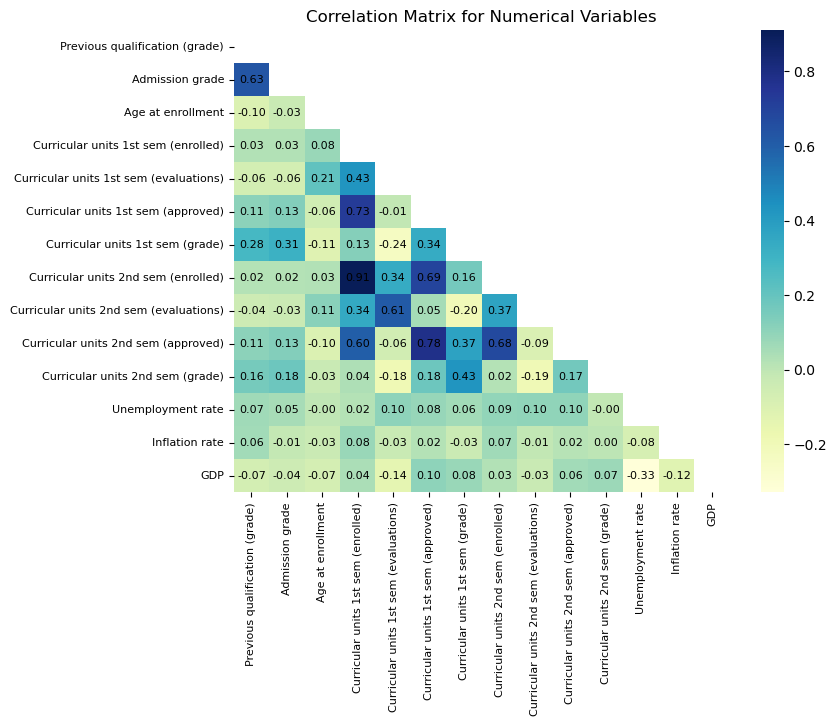

In [7]:
# Categorical correlation matrix: https://medium.com/@manindersingh120996/understanding-categorical-correlations-with-chi-square-test-and-cramers-v-a54fe153b1d6
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def correlation_matrix_categorical(df):
    categorical_df = df.select_dtypes(include = ["category"])
    plt.figure(figsize = (8, 6))
    corr_matrix = pd.DataFrame(np.zeros((len(categorical_df.columns), len(categorical_df.columns))), 
                               index = categorical_df.columns, columns = categorical_df.columns)
    for i in range(len(categorical_df.columns)):
        for j in range(i, len(categorical_df.columns)):
            corr = cramers_v(categorical_df.iloc[:, i], categorical_df.iloc[:, j])
            corr_matrix.iloc[i, j] = corr
            corr_matrix.iloc[j, i] = corr
    mask = np.triu(np.ones_like(corr_matrix))
    heatmap = sns.heatmap(corr_matrix, cmap = "YlGnBu", mask = mask)
    # Add annotations manually
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            if not mask[i, j]:
                plt.text(j + 0.5, i + 0.5, "{:.2f}".format(corr_matrix.iloc[i, j]), 
                         ha = "center", va = "center", color = "black", fontsize = 8)
    plt.title("Correlation Matrix for Categorical Variables")
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize = 8)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize = 8)
    plt.show()
    
correlation_matrix_categorical(data)

# Numerical correlation matrix:
def correlation_matrix_numerical(df):
    numerical_df = df.select_dtypes(include = ['float64', 'int64'])
    plt.figure(figsize = (8, 6))
    mask = np.triu(np.ones_like(numerical_df.corr()))
    heatmap = sns.heatmap(numerical_df.corr(), cmap = "YlGnBu", mask = mask)
    # Add annotations manually
    for i in range(len(numerical_df.columns)):
        for j in range(len(numerical_df.columns)):
            if not mask[i, j]:
                plt.text(j + 0.5, i + 0.5, "{:.2f}".format(numerical_df.corr().iloc[i, j]),
                         ha = "center", va = "center", color = "black", fontsize = 8)
    plt.title("Correlation Matrix for Numerical Variables")
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize = 8)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize = 8)
    plt.show()

correlation_matrix_numerical(data)

# Dropping variables > 0.7 correlation:
data = dropping(data, ["Nationality", "Daytime/evening attendance", "Curricular units 1st sem (enrolled)", "Curricular units 1st sem (approved)"])

## Splitting data

In [8]:
# Splitting into train/test:
def split_data(df):
    train, test = train_test_split(df, test_size = 0.2, random_state = seed_value)
    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    return train, test

train, test = split_data(data)

In [9]:
# Splitting variables:
def split_variables(df, target):
    X = df.drop(target, axis = 1)
    y = df[target]
    return X, y

X_train, y_train = split_variables(train, "Target")
X_test, y_test = split_variables(test, "Target")

In [10]:
# Scaling numerical variables (https://datascience.stackexchange.com/questions/12321/whats-the-difference-between-fit-and-fit-transform-in-scikit-learn-models):
def data_scaler(df):
    numerical_cols = df.select_dtypes(include = ["int64", "float64"]).columns.tolist()
    scaler = StandardScaler().fit(X_train[numerical_cols])
    df[numerical_cols] = scaler.transform(df[numerical_cols])
    return df

X_train = data_scaler(X_train)
X_test = data_scaler(X_test)

In [11]:
# One-hot encoding categorical variables:
def one_hot_encode(df):
    categorical_cols = df.select_dtypes(include = ["category"]).columns.tolist()
    for column in categorical_cols:
        encoded_cols = pd.get_dummies(df[column], prefix = column, prefix_sep = "_")
        encoded_cols = encoded_cols.astype(int)
        df = pd.concat([df.drop(column, axis = 1), encoded_cols], axis = 1)
    return df

X_train = one_hot_encode(X_train)
X_test = one_hot_encode(X_test)

In [12]:
# Hyperparameter tuning with SMOTE and cross-validation (https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html):
def hyperparameter_tuning(model, param_grid):
    f1_scorer = make_scorer(f1_score, average = "macro")
    skf = StratifiedKFold(n_splits = 5, random_state = seed_value, shuffle = True)
    pipeline = make_pipeline(SMOTE(random_state = seed_value), model)
    new_params = {"{0}__{1}".format(model.__class__.__name__.lower(), key): value for key, value in param_grid.items()}
    random_search = RandomizedSearchCV(pipeline, param_distributions = new_params, cv = skf, error_score = "raise", 
                                       scoring = f1_scorer, return_train_score = True, random_state = seed_value)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    return best_model, best_params, best_score

## Building models

### Model 1 - XGBoost (baseline)

In [13]:
xgb_model = XGBClassifier() # https://www.sciencedirect.com/science/article/pii/S2214716023000271

param_grid_xgb = {"max_depth": [5, 6, 7, 8, 9],
                  "n_estimators": list(range(200, 301, 10)),
                  "learning_rate": [0.1, 0.05, 0.02, 0.01],
                  "reg_alpha": [0.075, 0.1, 0.125, 0.15],
                  "reg_lambda": [0.2, 0.25, 0.3, 0.5]}

best_model_xgb, best_params_xgb, best_score_xgb = hyperparameter_tuning(xgb_model, param_grid_xgb)

print(best_model_xgb)
print(best_params_xgb)
print(best_score_xgb)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strat

### Model 2 - ANN

In [14]:
ann_model = MLPClassifier() # https://www.sciencedirect.com/science/article/pii/S2666920X21000126?via%3Dihub

param_grid_ann = {"hidden_layer_sizes": [(50, )],
                  "activation": ["tanh"],
                  "solver": ["sgd", "adam"],
                  "learning_rate_init": [0.001, 0.0005, 0.0001, 0.00005, 0.00001],
                  "momentum": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                  "max_iter": [3000, 5000, 10000],
                  "verbose": [False],
                  "early_stopping": [False],
                  "n_iter_no_change": [10]}

best_model_ann, best_params_ann, best_score_ann = hyperparameter_tuning(ann_model, param_grid_ann)

print(best_model_ann)
print(best_params_ann)
print(best_score_ann)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(50,),
                               learning_rate_init=1e-05, max_iter=5000,
                               momentum=0.3))])
{'mlpclassifier__verbose': False, 'mlpclassifier__solver': 'adam', 'mlpclassifier__n_iter_no_change': 10, 'mlpclassifier__momentum': 0.3, 'mlpclassifier__max_iter': 5000, 'mlpclassifier__learning_rate_init': 1e-05, 'mlpclassifier__hidden_layer_sizes': (50,), 'mlpclassifier__early_stopping': False, 'mlpclassifier__activation': 'tanh'}
0.6387510700674703


### Model 3 - Voting (NB, DT, SVM, and KNN)

In [15]:
# NB classifier:
nb_classifier = GaussianNB() # https://ieeexplore.ieee.org/document/10082724

param_grid_nb = {"var_smoothing": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.1, 1, 10, 100, 1000]}

best_model_nb, best_params_nb, best_score_nb = hyperparameter_tuning(nb_classifier, param_grid_nb)

print(best_model_nb)
print(best_params_nb)
print(best_score_nb)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('gaussiannb', GaussianNB(var_smoothing=0.1))])
{'gaussiannb__var_smoothing': 0.1}
0.5260687828575225


In [16]:
# DT classifier:
dt_classifier = DecisionTreeClassifier() # https://ieeexplore.ieee.org/document/10349050

param_grid_dt = {"criterion": ["gini", "entropy"],
                 "max_depth": [None, 10, 20, 30, 40, 50],
                 "min_samples_split": [2, 5, 10, 20, 30, 50],
                 "min_samples_leaf": [1, 2, 4, 8, 10, 20]}

best_model_dt, best_params_dt, best_score_dt = hyperparameter_tuning(dt_classifier, param_grid_dt)

print(best_model_dt)
print(best_params_dt)
print(best_score_dt)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=30, min_samples_leaf=8,
                                        min_samples_split=30))])
{'decisiontreeclassifier__min_samples_split': 30, 'decisiontreeclassifier__min_samples_leaf': 8, 'decisiontreeclassifier__max_depth': 30, 'decisiontreeclassifier__criterion': 'gini'}
0.5780819631829683


In [17]:
# SVM classifier:
svm_classifier = SVC(probability = True) # https://ieeexplore.ieee.org/document/9065509 / https://ieeexplore.ieee.org/document/10082724

param_grid_svm = {"kernel": ["linear", "rbf", "sigmoid"],
                  "C": [0.01, 0.1, 1], 
                  "gamma": [0.001, 0.01, 0.1, 1]}

best_model_svm, best_params_svm, best_score_svm = hyperparameter_tuning(svm_classifier, param_grid_svm)

print(best_model_svm)
print(best_params_svm)
print(best_score_svm)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('svc',
                 SVC(C=0.1, gamma=0.1, kernel='linear', probability=True))])
{'svc__kernel': 'linear', 'svc__gamma': 0.1, 'svc__C': 0.1}
0.6364281971849425


In [18]:
# KNN classifier:
knn_classifier = KNeighborsClassifier() # https://ieeexplore.ieee.org/document/10349050

param_grid_knn = {"n_neighbors": list(range(3, 102, 2)),
                  "weights": ["uniform", "distance"],
                  "metric": ["euclidean", "manhattan"],
                  "leaf_size": list(range(10, 100, 10))}

best_model_knn, best_params_knn, best_score_knn = hyperparameter_tuning(knn_classifier, param_grid_knn)

print(best_model_knn)
print(best_params_knn)
print(best_score_knn)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(leaf_size=70, metric='manhattan',
                                      n_neighbors=63, weights='distance'))])
{'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 63, 'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__leaf_size': 70}
0.5383151919127371


In [19]:
vt_model = VotingClassifier(estimators = [("nb", best_model_nb), ("dt", best_model_dt), 
                                          ("svm", best_model_svm), ("knn", best_model_knn)],
                           voting = "soft") # https://www.researchgate.net/publication/361101272_Utilization_of_Ensemble_Techniques_for_Prediction_of_the_Academic_Performance_of_Students

param_grid_vt = {"weights": [[1, 1, 1, 1], [2, 1, 1, 1], [1, 2, 1, 1], [1, 1, 2, 1], [1, 1, 1, 2], [2, 2, 1, 1],
                             [2, 1, 2, 1], [2, 1, 1, 2], [1, 2, 2, 1], [1, 2, 1, 2], [1, 1, 2, 2], [2, 2, 2, 1],
                             [2, 2, 1, 2], [2, 1, 2, 2], [1, 2, 2, 2], [2, 2, 2, 2]]}

best_model_vt, best_params_vt, best_score_vt = hyperparameter_tuning(vt_model, param_grid_vt)

print(best_model_vt)
print(best_params_vt)
print(best_score_vt)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('votingclassifier',
                 VotingClassifier(estimators=[('nb',
                                               Pipeline(steps=[('smote',
                                                                SMOTE(random_state=101)),
                                                               ('gaussiannb',
                                                                GaussianNB(var_smoothing=0.1))])),
                                              ('dt',
                                               Pipeline(steps=[('smote',
                                                                SMOTE(random_state=101)),
                                                               ('decisiontreeclassifier',
                                                                DecisionTreeClassifier(max_depth=30,
                                                                                       min_samples_leaf=8,
    

### Model 4 - Stacking (RF, XGBoost, GB, and FNN)

In [20]:
# RF classifier:
rf_classifier = RandomForestClassifier() # https://link.springer.com/article/10.1007/s10462-020-09896-5#Tab2

param_grid_rf = {"n_estimators": [50, 100, 200],
                 "max_depth": [5, 8, 10],
                 "min_samples_split": [2, 5, 10, 20],
                 "min_samples_leaf": [1, 25, 50, 70],
                 "max_features": ["log2", "sqrt", 0.25, 1]}

best_model_rf, best_params_rf, best_score_rf = hyperparameter_tuning(rf_classifier, param_grid_rf)

print(best_model_rf)
print(best_params_rf)
print(best_score_rf)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, max_features=0.25,
                                        min_samples_split=5,
                                        n_estimators=200))])
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 0.25, 'randomforestclassifier__max_depth': 10}
0.6264778069014827


In [21]:
# XGB classifier:
print(best_model_xgb)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strat

In [22]:
# GB classifier: 
gb_classifier = GradientBoostingClassifier() # https://link.springer.com/article/10.1007/s10462-020-09896-5#Tab2

param_grid_gb = {"n_estimators": [50, 100, 200],
                    "learning_rate": [0.025, 0.05, 0.1, 0.2, 0.3], 
                    "max_depth": [2, 3, 5, 7, 10],
                    "min_samples_split": [2, 5, 10, 20],
                    "max_features": ["log2", "sqrt", 0.25, 1],
                    "subsample": [0.15, 0.5, 0.75, 1]}

best_model_gb, best_params_gb, best_score_gb = hyperparameter_tuning(gb_classifier, param_grid_gb)

print(best_model_gb)
print(best_params_gb)
print(best_score_gb)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.025, max_depth=10,
                                            max_features=0.25,
                                            min_samples_split=20,
                                            n_estimators=200,
                                            subsample=0.15))])
{'gradientboostingclassifier__subsample': 0.15, 'gradientboostingclassifier__n_estimators': 200, 'gradientboostingclassifier__min_samples_split': 20, 'gradientboostingclassifier__max_features': 0.25, 'gradientboostingclassifier__max_depth': 10, 'gradientboostingclassifier__learning_rate': 0.025}
0.6372052016008325


In [23]:
# FNN classifier:
print(best_model_ann)

Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(50,),
                               learning_rate_init=1e-05, max_iter=5000,
                               momentum=0.3))])


In [24]:
st_model = StackingClassifier(estimators = [("rf", best_model_rf), ("xgb", best_model_xgb), ("gb", best_model_gb)], 
                              final_estimator = best_model_ann) # https://www.sciencedirect.com/science/article/pii/S2666920X22000212

param_grid_st = {"stack_method": ["auto", "predict_proba"],
                 "passthrough": [True, False]}

best_model_st, best_params_st, best_score_st = hyperparameter_tuning(st_model, param_grid_st)

print(best_model_st)
print(best_params_st)
print(best_score_st)

C:\Users\yase_\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Pipeline(steps=[('smote', SMOTE(random_state=101)),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('rf',
                                                 Pipeline(steps=[('smote',
                                                                  SMOTE(random_state=101)),
                                                                 ('randomforestclassifier',
                                                                  RandomForestClassifier(max_depth=10,
                                                                                         max_features=0.25,
                                                                                         min_samples_split=5,
                                                                                         n_estimators=200))])),
                                                ('xgb',
                                                 Pipeline(steps=[('smote',
                               

## Model Comparison

In [36]:
# F1-scores on training:
print("F1 score training xgb:", best_score_xgb)
print("F1 score training ann:", best_score_ann)
print("F1 score training vt:", best_score_vt)
print("F1 score training st:", best_score_st)

F1 score training xgb: 0.6385071029735887
F1 score training ann: 0.6387510700674703
F1 score training vt: 0.6336132270389014
F1 score training st: 0.645389658502946


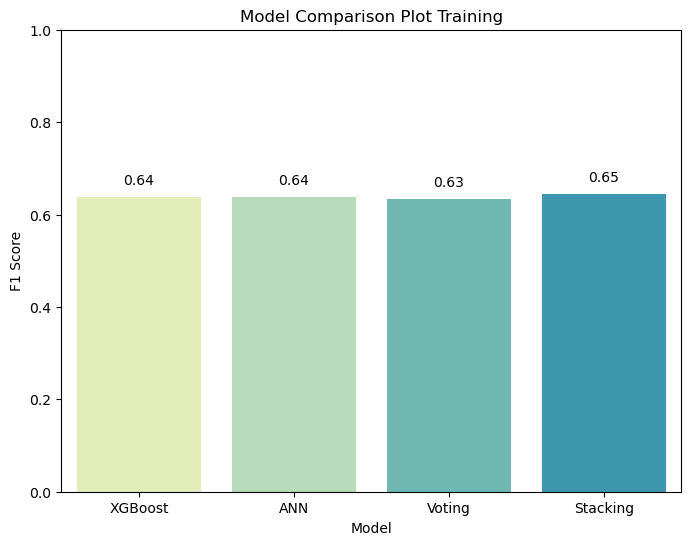

In [37]:
# Visualization model comparison training:
def barplot_models(model_scores):
    model_names = list(model_scores.keys())
    f1_scores = list(model_scores.values())
    plt.figure(figsize = (8, 6))
    sns.set_palette("YlGnBu")
    bars = sns.barplot(x = model_names, y = f1_scores)
    plt.title("Model Comparison Plot Training")
    plt.xlabel("Model")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    for bar, f1_score in zip(bars.patches, f1_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{f1_score:.2f}", ha = "center", va = "bottom")
    plt.show()

barplot_models(model_scores = {"XGBoost": best_score_xgb, "ANN": best_score_ann, "Voting": best_score_vt, "Stacking": best_score_st})

In [34]:
# Predictions:
def f1_models(best_model):
    y_pred = best_model.predict(X_test)
    y_true = y_test
    f1 = f1_score(y_true, y_pred, average = "macro")
    return f1

xgb_f1 = f1_models(best_model_xgb)
ann_f1 = f1_models(best_model_ann)
vt_f1 = f1_models(best_model_vt)
st_f1 = f1_models(best_model_st)

# F1-scores on testing:
print("F1 score testing xgb:", xgb_f1)
print("F1 score testing ann:", ann_f1)
print("F1 score testing vt:", vt_f1)
print("F1 score testing st:", st_f1)

F1 score testing xgb: 0.37045258354914296
F1 score testing ann: 0.13306313972663328
F1 score testing vt: 0.4367691413276315
F1 score testing st: 0.11171171171171172


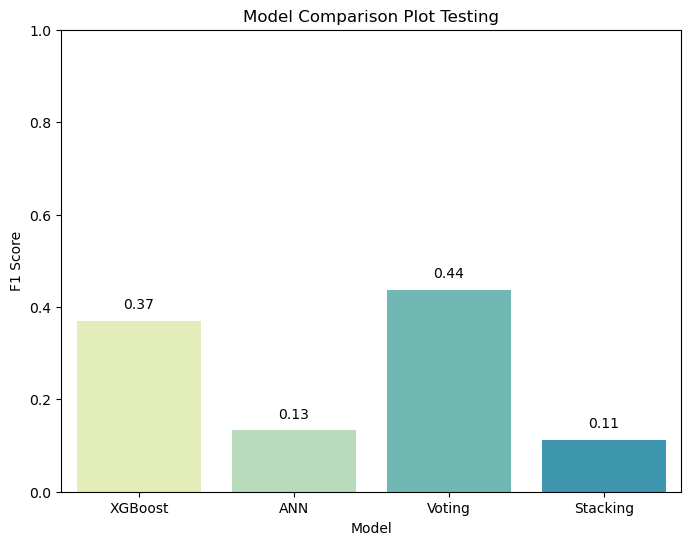

In [35]:
# Visualization model comparison testing:
def barplot_models(model_scores):
    model_names = list(model_scores.keys())
    f1_scores = list(model_scores.values())
    plt.figure(figsize = (8, 6))
    sns.set_palette("YlGnBu")
    bars = sns.barplot(x = model_names, y = f1_scores)
    plt.title("Model Comparison Plot Testing")
    plt.xlabel("Model")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1) 
    for bar, f1_score in zip(bars.patches, f1_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{f1_score:.2f}", ha = "center", va = "bottom")
    plt.show()

barplot_models(model_scores = {"XGBoost": xgb_f1, "ANN": ann_f1, "Voting": vt_f1, "Stacking": st_f1})

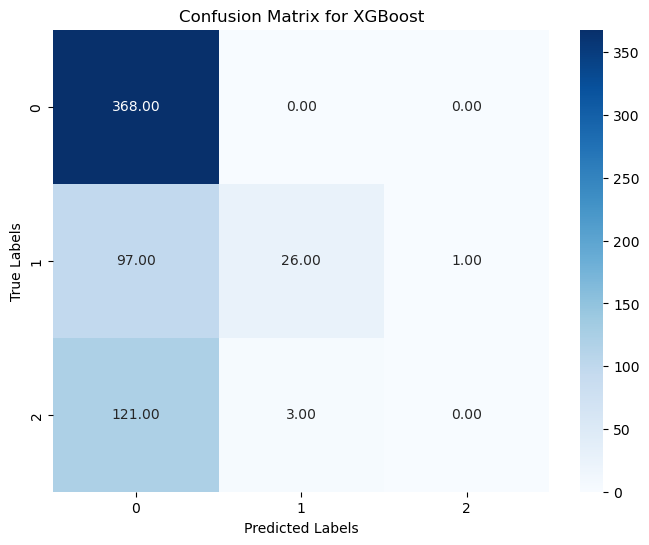

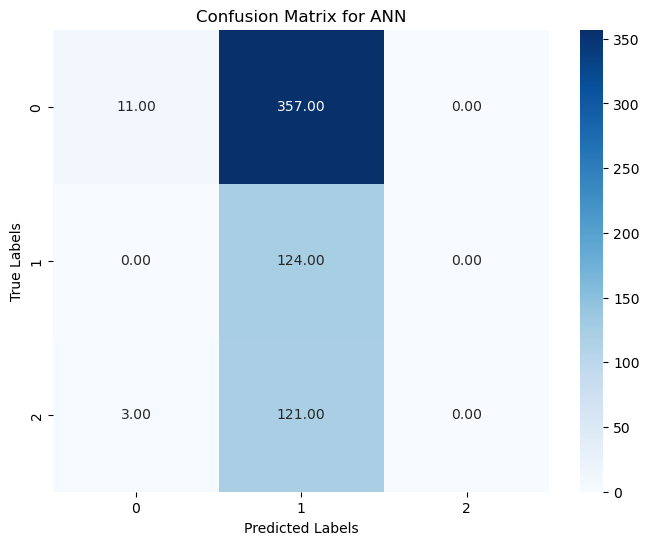

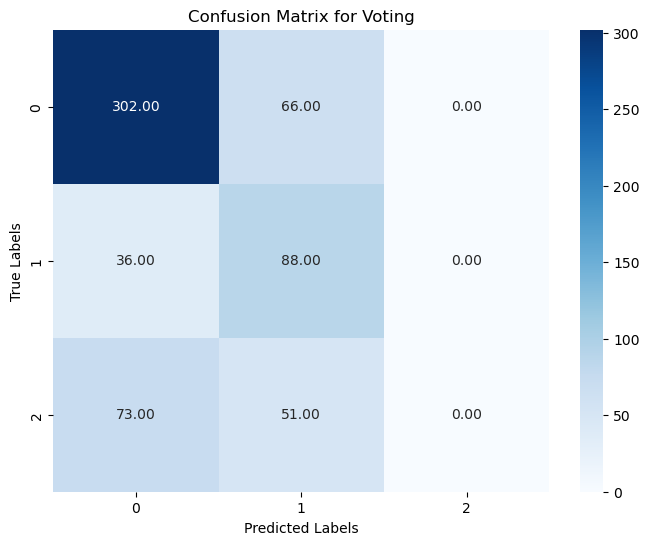

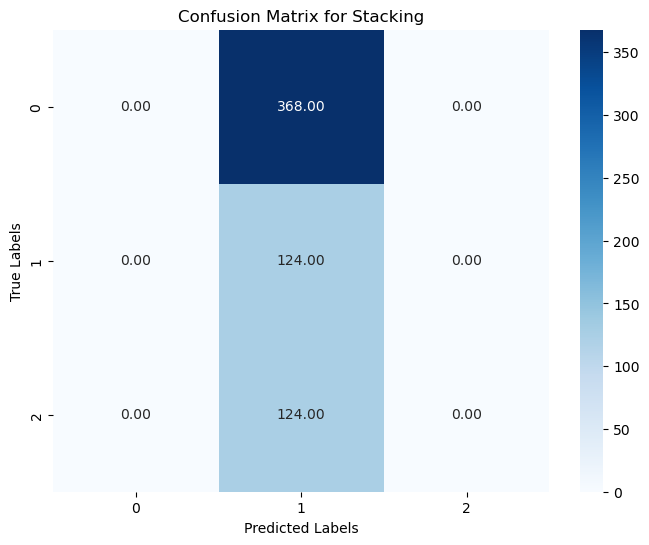

In [29]:
# Confusion matrices (difference predicted and actual):
def confusion_matrices(best_model, model_name):
    y_pred = best_model.predict(X_test)
    y_true = y_test
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (8, 6))
    custom_palette = ["#3182BD"]
    sns.set_palette(custom_palette)
    sns.heatmap(cm, annot = True, fmt = ".2f", cmap = "Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    return cm

xgb_cm = confusion_matrices(best_model_xgb, "XGBoost")
ann_cm = confusion_matrices(best_model_ann, "ANN")
vt_cm = confusion_matrices(best_model_vt, "Voting")
st_cm = confusion_matrices(best_model_st, "Stacking")

In [30]:
# Evaluation metrics:
def calculate_metrics(cm):
    metrics = {}
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        accuracy = (TP + TN) / cm.sum() if cm.sum() != 0 else 0
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        metrics[i] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1_score}
    return metrics

xgb_metrics = calculate_metrics(xgb_cm)
ann_metrics = calculate_metrics(ann_cm)
vt_metrics = calculate_metrics(vt_cm)
st_metrics = calculate_metrics(st_cm)

print("Evaluation metrics xgb:", xgb_metrics)
print("Evaluation metrics ann:", ann_metrics)
print("Evaluation metrics vt:", vt_metrics)
print("Evaluation metrics st:", st_metrics)

Evaluation metrics xgb: {0: {'accuracy': 0.6461038961038961, 'precision': 0.6279863481228669, 'recall': 1.0, 'f1_score': 0.7714884696016772}, 1: {'accuracy': 0.836038961038961, 'precision': 0.896551724137931, 'recall': 0.20967741935483872, 'f1_score': 0.3398692810457516}, 2: {'accuracy': 0.797077922077922, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0}}
Evaluation metrics ann: {0: {'accuracy': 0.4155844155844156, 'precision': 0.7857142857142857, 'recall': 0.029891304347826088, 'f1_score': 0.05759162303664921}, 1: {'accuracy': 0.22402597402597402, 'precision': 0.2059800664451827, 'recall': 1.0, 'f1_score': 0.34159779614325064}, 2: {'accuracy': 0.7987012987012987, 'precision': 0, 'recall': 0.0, 'f1_score': 0}}
Evaluation metrics vt: {0: {'accuracy': 0.7159090909090909, 'precision': 0.7347931873479319, 'recall': 0.8206521739130435, 'f1_score': 0.7753530166880616}, 1: {'accuracy': 0.7516233766233766, 'precision': 0.4292682926829268, 'recall': 0.7096774193548387, 'f1_score': 0.534954407294

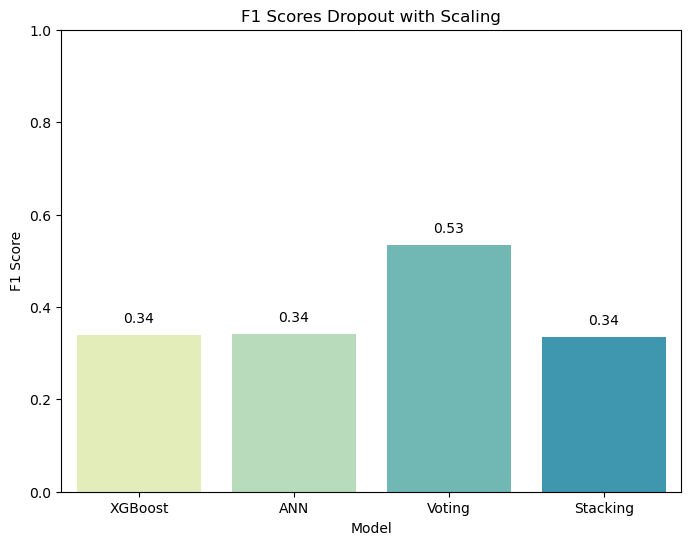

In [33]:
# Visualization model comparison dropout:

# Select F1 score for dropout:
xgb_f1_class_1 = xgb_metrics[1]["f1_score"]
ann_f1_class_1 = ann_metrics[1]["f1_score"]
vt_f1_class_1 = vt_metrics[1]["f1_score"]
st_f1_class_1 = st_metrics[1]["f1_score"]

def barplot_models(model_scores):
    model_names = list(model_scores.keys())
    f1_scores = list(model_scores.values())
    plt.figure(figsize = (8, 6))
    sns.set_palette("YlGnBu")
    bars = sns.barplot(x = model_names, y = f1_scores)
    plt.title("F1 Scores Dropout with Scaling")
    plt.xlabel("Model")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    for bar, f1_score in zip(bars.patches, f1_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{f1_score:.2f}", ha = "center", va = "bottom")
    plt.show()

barplot_models(model_scores = {"XGBoost": xgb_f1_class_1, "ANN": ann_f1_class_1, "Voting": vt_f1_class_1, "Stacking": st_f1_class_1})